In [ ]:
# --- Core Libraries ---
import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# --- Statistics ---
from scipy.stats import pearsonr

# --- Interactive Widgets ---
import ipywidgets as widgets
from IPython.display import display, clear_output
from ipywidgets import interact, IntSlider, fixed

# --- Ratinabox Environment ---
from ratinabox.Environment import Environment
from ratinabox.Agent import Agent

# --- Custom Utilities ---
from network_utils1 import *

In [2]:
# Define environment
env = Environment()

# Generate trajectory function
def generate_trajectory(seed=None, T=600.0, dt=0.1):
    if seed is not None:
        np.random.seed(seed)  # Optional for reproducibility
    
    agent = Agent(env)
    agent.speed_mean = 0.08
    agent.speed_coherence_time = 0.7
    agent.rotation_velocity_std = 120 * np.pi / 180
    agent.rotational_velocity_coherence_time = 0.08

    for _ in range(int(T / dt)):
        agent.update(dt=dt)

    positions = np.array(agent.history["pos"]) * 10  # scale to grid
    return positions

In [ ]:
def run_WT_pipeline(positions):
    '''
    Simulates activity in a wild-type (WT) continuous attractor network model
    given an agent's trajectory. For each timepoint, computes the network’s 
    internal activation state and generates a spatial ratemap for each place cell.

    Parameters:

    positions : np.ndarray
        Sequence of (x, y) coordinates representing the agent’s trajectory.

    Returns:

    results : np.ndarray
        Flattened network activation over time (timesteps × cells).
    ratemaps : np.ndarray
        Spatial firing maps (ratemaps) for each attractor cell.
    '''

    # Set up network and sensory cell parameters
    rows = 10
    cols = 10
    att_cell = rows * cols
    nSensoryCells = 50
    weightsMat = np.zeros((rows, cols, att_cell))

    # Convert positions to integer spatial indices
    pos_indices = positions.astype(int)

    # Create a mapping from cell index to 2D grid coordinates (previous PC index)
    state_i = np.arange(rows * cols)
    rows_i = state_i // cols
    cols_i = state_i % rows
    states = (rows_i, cols_i)
    pc_coords = np.column_stack(states)

    # Build 2D Gaussian firing fields for each of the 50 sensory cells
    sensoryFiringFields = np.zeros((rows, cols, nSensoryCells))
    centres = (env.sample_positions(n=50, method='uniform') * 10).astype(int) #using ratinAbox function
    X, Y = np.meshgrid(np.arange(10), np.arange(10)) #grid to calculate distants to compute gaussian
    for i, (cx, cy) in enumerate(centres): 
        sensoryFiringFields[:, :, i] = gaussian(X, Y, cx, cy, 1.5)

    # Initialize the matrix for sensory-to-place cell projections
    sensoryWeights = np.zeros((nSensoryCells, att_cell))

    # Set up recurrent weights for each attractor cell
    for pc in range(att_cell):
        # Assign a self-weight of 1 to the cell's own position
        weightsMat[pc_coords[pc][0], pc_coords[pc][1], pc] = 1

        # Assign a weight of 0.5 to each of its 4 immediate neighbours
        for dr, dc in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
            nr, nc = pc_coords[pc][0] + dr, pc_coords[pc][1] + dc 
            if 0 <= nr < rows and 0 <= nc < cols:
                weightsMat[nr, nc, pc] = 0.5

        # Also assign the sensory weights at the cell's location
        sensoryWeights[:, pc] = sensoryFiringFields[pc_coords[pc][0], pc_coords[pc][1], :]

    # Compute the external sensory input at each timestep
    attractor_activations = []
    for (r, c) in pos_indices:
        currentSensoryActivity = sensoryFiringFields[r, c, :] # Get the sensory activity at the current att cell position
        currentSensoryActivity = np.transpose([currentSensoryActivity]) # Transpose to make it a column vector
        currentSensoryActivity = np.matlib.repmat(currentSensoryActivity, 1, att_cell) # Repeat it to match the number of att cells
        pcActivations = currentSensoryActivity * sensoryWeights # Compute the sensory input to each att cell by multiplying the current sensory activity with the sensory weights
        pcActivations = np.sum(pcActivations, axis=0).reshape(rows, cols)
        pcActivationsNorm = pcActivations / np.max(pcActivations)
        attractor_activations.append((pcActivationsNorm))

    # Initialise the network state with small random noise
    rng = np.random.default_rng()
    NetAct = rng.normal(loc=0.0, scale=0.05, size=(10, 10))
    NetAct = np.clip(NetAct, 0, 1)

    # Prepare to store the full network activity and per-cell ratemaps
    results = np.zeros((len(pos_indices), att_cell))
    ratemaps = np.zeros((att_cell, rows, cols))

    # Loop over each timestep to update network state
    for t in range(len(pos_indices)):
        activation = attractor_activations[t]  # Sensory input at this timestep
        NetInput = np.zeros((rows, cols))

        # Recurrent update from all cells
        for pc in range(att_cell): 
            NetInput += weightsMat[:, :, pc] * NetAct[pc_coords[pc][0], pc_coords[pc][1]]
            NetInput += activation
            NetInput = (NetInput - NetInput.min()) / (NetInput.max() - NetInput.min())  # Min-max normalize

        # Update network activity
        NetAct = NetInput
        results[t] = NetAct.flatten().copy()

        # Update the ratemap for each cell at the agent’s current location
        x, y = pos_indices[t] # Get the position the agent was at during timestep t.
        ratemaps[:, x, y] += NetAct.flatten() / len(pos_indices) 
        # flatten activation level of all 100 place cells at t#
        # accumulating the average over time by dividing by the total number of steps.
        # ratemap holds the mean activation of each cell at each location.

    return results, ratemaps

In [ ]:
def run_cell_deletion_pipeline(positions, cell_deletion_percent):
    '''
    Simulates a continuous attractor network with partial cell deletion 
    given an agent trajectory. 
    A percentage of attractor cells are randomly skipped during recurrent 
    and sensory weight construction.

    Parameters:
    
    positions : np.ndarray
        Array of (x, y) positions representing the trajectory.

    deletion_percent : float

    Returns:
    
    results : np.ndarray
        Network activation (timesteps × cells).

    ratemaps : np.ndarray
        Firing rate maps for each place cell over the environment.
    '''

    # Set up grid and number of place/sensory cells
    rows = 10
    cols = 10
    att_cell = rows * cols
    nSensoryCells = 50
    weightsMat = np.zeros((rows, cols, att_cell))

    # Convert agent's trajectory to integer spatial indices
    pos_indices = positions.astype(int)

    # Map each cell index to its (row, col) position
    state_i = np.arange(rows * cols)
    rows_i = state_i // cols
    cols_i = state_i % rows
    pc_coords = np.column_stack((rows_i, cols_i))

    # Create Gaussian firing fields for each sensory cell
    sensoryFiringFields = np.zeros((rows, cols, nSensoryCells))
    centres = (env.sample_positions(n=50, method='uniform') * 10).astype(int)
    X, Y = np.meshgrid(np.arange(10), np.arange(10))
    for i, (cx, cy) in enumerate(centres): 
        sensoryFiringFields[:, :, i] = gaussian(X, Y, cx, cy, 1.5) 

    # Sensory cell → attractor cell weight matrix
    sensoryWeights = np.zeros((nSensoryCells, att_cell))

    # Construct recurrent weights (skipping a % of cells)
    for pc in range(att_cell):
        if np.random.rand() < cell_deletion_percent:
            continue  # Skip this cell entirely (simulate deletion)

        # Set self-weight to 1
        weightsMat[pc_coords[pc][0], pc_coords[pc][1], pc] = 1

        # Set weights to 4-connected neighbors to 0.5
        for dr, dc in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
            nr, nc = pc_coords[pc][0] + dr, pc_coords[pc][1] + dc 
            if 0 <= nr < rows and 0 <= nc < cols:
                weightsMat[nr, nc, pc] = 0.5

        # Connect sensory weights to this attractor cell
        sensoryWeights[:, pc] = sensoryFiringFields[pc_coords[pc][0], pc_coords[pc][1], :]

    # Precompute external sensory input at each timestep
    attractor_activations = []
    for (r, c) in pos_indices:
        currentSensoryActivity = sensoryFiringFields[r, c, :] # Get the sensory activity at the current att cell position
        currentSensoryActivity = np.transpose([currentSensoryActivity]) # Transpose to make it a column vector
        currentSensoryActivity = np.matlib.repmat(currentSensoryActivity, 1, att_cell) # Repeat it to match the number of att cells
        pcActivations = currentSensoryActivity * sensoryWeights # Compute the sensory input to each att cell by multiplying the current sensory activity with the sensory weights
        pcActivations = np.sum(pcActivations, axis=0).reshape(rows, cols)
        pcActivationsNorm = pcActivations / np.max(pcActivations)
        attractor_activations.append((pcActivationsNorm))

    # Initialise the network with low noise
    rng = np.random.default_rng()
    NetAct = rng.normal(loc=0.0, scale=0.05, size=(10, 10))
    NetAct = np.clip(NetAct, 0, 1)

    # Set up output arrays
    results = np.zeros((len(pos_indices), att_cell))
    ratemaps = np.zeros((att_cell, rows, cols))

    # Simulate network dynamics over the trajectory
    for t in range(len(pos_indices)):
        activation = attractor_activations[t]
        NetInput = np.zeros((rows, cols))

        # Recurrent + external input to network
        for pc in range(att_cell): 
            NetInput += weightsMat[:, :, pc] * NetAct[pc_coords[pc][0], pc_coords[pc][1]]
            NetInput += activation
            NetInput = (NetInput - NetInput.min()) / (NetInput.max() - NetInput.min())

        # Update state
        NetAct = NetInput
        results[t] = NetAct.flatten().copy()

        # Update the ratemap for each cell at the agent’s current location
        x, y = pos_indices[t] # Get the position the agent was at during timestep t.
        ratemaps[:, x, y] += NetAct.flatten() / len(pos_indices) 
        # flatten activation level of all 100 place cells at t#
        # accumulating the average over time by dividing by the total number of steps.
        # ratemap holds the mean activation of each cell at each location.

    return results, ratemaps

In [289]:
def run_synaptic_deletion_pipeline(positions, synaptic_deletion_percent=0.6):
    '''
    Simulates a continuous attractor network with partial synaptic weight deletion 
    given an agent trajectory. 
    A percentage of weightts(0.5) are randomly skipped during recurrent 
    and sensory weight construction.
    

    
    Parameters:
    
    positions : np.ndarray
        Array of (x, y) coordinates representing the agent’s trajectory.
    
    synaptic_deletion_percent : float
    
    Returns:

    results : np.ndarray
        Network activity over time, flattened per timestep (timesteps × 100).
    ratemaps : np.ndarray
        Mean spatial activation per attractor cell (100 × 10 × 10).
    '''

    # Set up network and sensory field dimensions
    rows = 10
    cols = 10
    att_cell = rows * cols
    nSensoryCells = 50
    weightsMat = np.zeros((rows, cols, att_cell))  # recurrent weights

    # Convert trajectory positions to integer bin indices
    pos_indices = positions.astype(int)

    # Map place cell indices (0–99) to 2D grid coordinates
    state_i = np.arange(att_cell)
    rows_i = state_i // cols
    cols_i = state_i % rows
    pc_coords = np.column_stack((rows_i, cols_i))

    # Generate spatially-tuned 2D Gaussian firing fields for each sensory cell
    sensoryFiringFields = np.zeros((rows, cols, nSensoryCells))
    centres = (env.sample_positions(n=50, method='uniform') * 10).astype(int)
    X, Y = np.meshgrid(np.arange(10), np.arange(10))
    for i, (cx, cy) in enumerate(centres): 
        sensoryFiringFields[:, :, i] = gaussian(X, Y, cx, cy, 1.5)

    # Create projection weights from sensory → attractor cells
    sensoryWeights = np.zeros((nSensoryCells, att_cell))

    # Assign recurrent weights and delete lateral connections with some probability
    for pc in range(att_cell): 
        # Assign self-connection weight of 1
        weightsMat[pc_coords[pc][0], pc_coords[pc][1], pc] = 1

        # Randomly skip assigning neighbour weights if synaptic deletion occurs
        if np.random.rand() < synaptic_deletion_percent:
            continue

        # Assign 0.5 weights to 4-connected neighbours (if within bounds)
        for dr, dc in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
            nr, nc = pc_coords[pc][0] + dr, pc_coords[pc][1] + dc 
            if 0 <= nr < rows and 0 <= nc < cols:
                weightsMat[nr, nc, pc] = 0.5

        # Store the sensory tuning profile at this place cell’s grid location
        sensoryWeights[:, pc] = sensoryFiringFields[pc_coords[pc][0], pc_coords[pc][1], :]

    # Precompute the sensory input (external drive) at each timestep
    attractor_activations = []
    for (r, c) in pos_indices:
        currentSensoryActivity = sensoryFiringFields[r, c, :]  # Get 50-dim sensory activity
        currentSensoryActivity = np.transpose([currentSensoryActivity])  # (50, 1)
        currentSensoryActivity = np.matlib.repmat(currentSensoryActivity, 1, att_cell)  # (50, 100)
        pcActivations = currentSensoryActivity * sensoryWeights  # input from all sensory cells to each PC
        pcActivations = np.sum(pcActivations, axis=0).reshape(rows, cols)
        pcActivationsNorm = pcActivations / np.max(pcActivations)  # normalize for stability
        attractor_activations.append(pcActivationsNorm)

    # Initialise the network with low random noise (clipped to 0–1)
    rng = np.random.default_rng()
    NetAct = rng.normal(loc=0.0, scale=0.05, size=(10, 10))
    NetAct = np.clip(NetAct, 0, 1)

    # Arrays to store full network activity and per-cell spatial ratemaps
    results = np.zeros((len(pos_indices), att_cell))
    ratemaps = np.zeros((att_cell, rows, cols))

    # Run simulation across each timestep
    for t in range(len(pos_indices)):
        activation = attractor_activations[t]
        NetInput = np.zeros((rows, cols))

        # Recurrent drive from all attractor cells
        for pc in range(att_cell): 
            NetInput += weightsMat[:, :, pc] * NetAct[pc_coords[pc][0], pc_coords[pc][1]]

        # Add sensory input and normalize activation
        NetInput += activation
        NetInput = (NetInput - NetInput.min()) / (NetInput.max() - NetInput.min())
        NetAct = NetInput

        # Store network state
        results[t] = NetAct.flatten().copy()

        # Update firing rate maps at the agent’s current location
        x, y = pos_indices[t]
        ratemaps[:, x, y] += NetAct.flatten() / len(pos_indices)

    return results, ratemaps

In [ ]:
def run_gaussian_noise_pipeline(positions, noise_sigma, spike_fraction = 0.1):
    '''
     Simulates a continuous attractor network with partial synaptic weight deletion 
    given an agent trajectory. 
    A percentage of weightts(0.5) are randomly skipped during recurrent 
    and sensory weight construction.

    Parameters:

    positions : np.ndarray
        Sequence of (x, y) coordinates representing the agent’s trajectory.

    noise_sigma:
        Standard deviation of Gaussian noise added to self-connection weights 
        during recurrent matrix construction. Controls the degree of variability 
        in recurrent weights to simulate synaptic perturbation.

    Returns:

    results : np.ndarray
        Flattened network activation over time (timesteps × cells).
    ratemaps : np.ndarray
        Spatial firing maps (ratemaps) for each attractor cell.
    '''

    # Set up network and sensory cell parameters
    rows = 10
    cols = 10
    att_cell = rows * cols
    nSensoryCells = 50
    weightsMat = np.zeros((rows, cols, att_cell))

    # Convert positions to integer spatial indices
    pos_indices = positions.astype(int)

    # Create a mapping from cell index to 2D grid coordinates (previous PC index)
    state_i = np.arange(rows * cols)
    rows_i = state_i // cols
    cols_i = state_i % rows
    states = (rows_i, cols_i)
    pc_coords = np.column_stack(states)

    # Build 2D Gaussian firing fields for each of the 50 sensory cells
    sensoryFiringFields = np.zeros((rows, cols, nSensoryCells))
    centres = (env.sample_positions(n=50, method='uniform') * 10).astype(int) #using ratinAbox function
    X, Y = np.meshgrid(np.arange(10), np.arange(10)) #grid to calculate distants to compute gaussian
    for i, (cx, cy) in enumerate(centres): 
        sensoryFiringFields[:, :, i] = gaussian(X, Y, cx, cy, 1.5)

    # Initialize the matrix for sensory-to-place cell projections
    sensoryWeights = np.zeros((nSensoryCells, att_cell))

    # Set up recurrent weights for each attractor cell
    for pc in range(att_cell):
        # Assign a self-weight of 1 to the cell's own position
        weightsMat[pc_coords[pc][0], pc_coords[pc][1], pc] = 1

        # Assign a weight of 0.5 to each of its 4 immediate neighbours
        for dr, dc in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
            nr, nc = pc_coords[pc][0] + dr, pc_coords[pc][1] + dc 
            if 0 <= nr < rows and 0 <= nc < cols:
                weightsMat[nr, nc, pc] = 0.5

        # Also assign the sensory weights at the cell's location
        sensoryWeights[:, pc] = sensoryFiringFields[pc_coords[pc][0], pc_coords[pc][1], :]

    # Compute the external sensory input at each timestep
    attractor_activations = []
    for (r, c) in pos_indices:
        currentSensoryActivity = sensoryFiringFields[r, c, :] # Get the sensory activity at the current att cell position
        currentSensoryActivity = np.transpose([currentSensoryActivity]) # Transpose to make it a column vector
        currentSensoryActivity = np.matlib.repmat(currentSensoryActivity, 1, att_cell) # Repeat it to match the number of att cells
        pcActivations = currentSensoryActivity * sensoryWeights # Compute the sensory input to each att cell by multiplying the current sensory activity with the sensory weights
        pcActivations = np.sum(pcActivations, axis=0).reshape(rows, cols)
        pcActivationsNorm = pcActivations / np.max(pcActivations)
        attractor_activations.append((pcActivationsNorm))

    # Initialise the network state with small random noise
    rng = np.random.default_rng()
    NetAct = rng.normal(loc=0.0, scale=0.05, size=(10, 10))
    NetAct = np.clip(NetAct, 0, 1)

    # Prepare to store the full network activity and per-cell ratemaps
    results = np.zeros((len(pos_indices), att_cell))
    ratemaps = np.zeros((att_cell, rows, cols))

    # Loop over each timestep to update network state
    for t in range(len(pos_indices)):
        activation = attractor_activations[t]  # Sensory input at this timestep
        NetInput = np.zeros((rows, cols))

        #  select random subset of cells to spike this timestep
        n_spikes = max(1, int(spike_fraction * att_cell)) # Compute number of spikes = spike_fraction × total cells
        spike_cells = np.random.choice(att_cell, size=n_spikes, replace=False) # Randomly pick which cell indices will spike this timestep
        

        # Recurrent update from all cells
        for pc in range(att_cell): 
            NetInput += weightsMat[:, :, pc] \
                        + np.random.normal(loc=0.0, scale=noise_sigma) \
                          * NetAct[pc_coords[pc][0], pc_coords[pc][1]]
            NetInput += activation
            NetInput = (NetInput - NetInput.min()) / (NetInput.max() - NetInput.min())  # Min-max normalize

        # --- ADDED: inject random firing spikes into NetInput
        for pc in spike_cells:
            r, c = pc_coords[pc] # Locate the grid position of the spiking cell
            NetInput[r, c] += np.random.normal(loc=0.0, scale=noise_sigma) # Add a Gaussian random ‘firing’ at that cell’s coordinate
        

        # Update network activity
        NetAct = NetInput
        results[t] = NetAct.flatten().copy()

        # Update the ratemap for each cell at the agent’s current location
        x, y = pos_indices[t] # Get the position the agent was at during timestep t.
        ratemaps[:, x, y] += NetAct.flatten() / len(pos_indices) 
        # flatten activation level of all 100 place cells at t#
        # accumulating the average over time by dividing by the total number of steps.
        # ratemap holds the mean activation of each cell at each location.

    return results, ratemaps

In [ ]:
def ratemap_consistency_all_pairs(
    pipeline_fn,
    num_runs: int = 10,
    bin_area: float = 4.0,
    show_plots: bool = True,
    pipeline_kwargs: dict = None,
    label: str = None 
):
    """
    For each place cell, compare its ratemap in every trajectory
    against its own ratemaps in all *other* trajectories (excluding self).
    
    Returns
    -------
    mean_corrs : np.ndarray, shape (nCells,)
        Mean Pearson correlation (self-cell vs. self-cell) across all 45 pairs.
    mean_pct_changes : np.ndarray, shape (nCells,)
        Mean % change in place field size across all pairs.
    mean_field_size : float
        Mean place field size across all cells and all trials.
    """

    pipeline_kwargs = pipeline_kwargs or {}

    # Run the model on 10 random trajectories
    ratemaps_list = []  # Holds 10 sets of ratemaps (1 per trial)
    sizes_list = []     # Holds 10 arrays of field sizes (1 per trial)

    for i in range(num_runs):
        positions = generate_trajectory()
        _, ratemaps = pipeline_fn(positions, **pipeline_kwargs)
        ratemaps_list.append(ratemaps)

        # Compute place field size per cell for this trajectory
        # Field size = number of bins where firing > 2× mean × bin_area
        sizes = np.zeros(ratemaps.shape[0])
        for k in range(ratemaps.shape[0]):
            rm = ratemaps[k]
            mean_rate = np.mean(rm)
            sizes[k] = np.sum(rm > 2 * mean_rate) * bin_area
        sizes_list.append(sizes)

    ratemaps_list = np.array(ratemaps_list)  # shape: (10, nCells, rows, cols)
    sizes_list = np.array(sizes_list)        # shape: (10, nCells)

    nTrials, nCells, _, _ = ratemaps_list.shape
    corrs = np.zeros(nCells)         # To store mean Pearson r per cell
    pct_changes = np.zeros(nCells)   # To store mean % field size change per cell

    for k in range(nCells):
        corr_vals = []  # Correlations across trial pairs for cell k
        pct_vals = []   # % field size changes across trial pairs for cell k

        for i in range(nTrials):
            rm_i = ratemaps_list[i, k].ravel()
            s_i = sizes_list[i, k]

            for j in range(nTrials):
                if i == j:
                    continue

                rm_j = ratemaps_list[j, k].ravel()
                s_j = sizes_list[j, k]

                # --- Pearson correlation between ratemaps of cell k in trial i vs j
                if np.std(rm_i) == 0 or np.std(rm_j) == 0:
                    continue
                r, _ = pearsonr(rm_i, rm_j)
                corr_vals.append(r)

                # --- % change in place field size = ((s_j - s_i) / s_i) * 100
                if s_i != 0:
                    pct = (s_j - s_i) / s_i * 100
                    pct_vals.append(pct)

        # Average across all 45 trial-pair comparisons for this cell
        corrs[k] = np.mean(corr_vals) if corr_vals else np.nan
        pct_changes[k] = np.mean(pct_vals) if pct_vals else np.nan

    # Mean place field size across all cells and trials
    mean_field_size = np.nanmean(sizes_list)

    print(f"\n——— All Pairwise Trial Consistency (Per Cell) ———")
    print(f"Mean correlation (excl. NaN): {np.nanmean(corrs):.3f}")
    print(f"Mean % change in field size: {np.nanmean(pct_changes):.1f}%")
    print(f"Mean place field size (across all trials): {mean_field_size:.2f}")

    if show_plots:
        # Infer a readable label from the pipeline function name
        pipeline_name = pipeline_fn.__name__.replace("run_", "").replace("_pipeline", "").replace("_", " ").title()

        # Histogram: Mean correlation per cell
        plt.figure(figsize=(7, 3))
        vals = corrs[~np.isnan(corrs)]
        bins = 1 if np.all(vals == vals[0]) else 20
        rng = (vals[0] - 0.01, vals[0] + 0.01) if bins == 1 else None
        plt.hist(vals, bins=bins, range=rng, edgecolor='k')
        plt.xlabel("Mean Pearson correlation (across all pairwise comparisons)")
        plt.ylabel("Cell count")
        plt.title(f"Ratemap Consistency 10 Trajectories — {label}")
        plt.tight_layout()
        plt.show()

        # Histogram: Mean % change in place field size
        plt.figure(figsize=(5, 5))
        plt.hist(pct_changes[~np.isnan(pct_changes)], bins=20, edgecolor='k')
        plt.xlabel("Mean % change in place field size")
        plt.ylabel("Cell count")
        plt.title(f"Field Size Stability Across 10 Trajectories— {label}")
        plt.tight_layout()
        plt.show()

    return corrs, pct_changes, mean_field_size

In [ ]:
corrs, pct_changes, mean_field_size = ratemap_consistency_all_pairs(
    run_synaptic_deletion_pipeline,
    num_runs=10,
    bin_area=4.0,
    label="gaussian noise - 0.5"
)


——— All Pairwise Trial Consistency (Per Cell) ———
Mean correlation (excl. NaN): 0.735
Mean % change in field size: 2.3%
Mean place field size (across all trials): 67.95


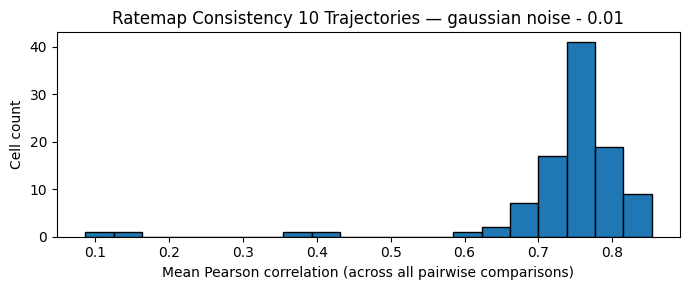

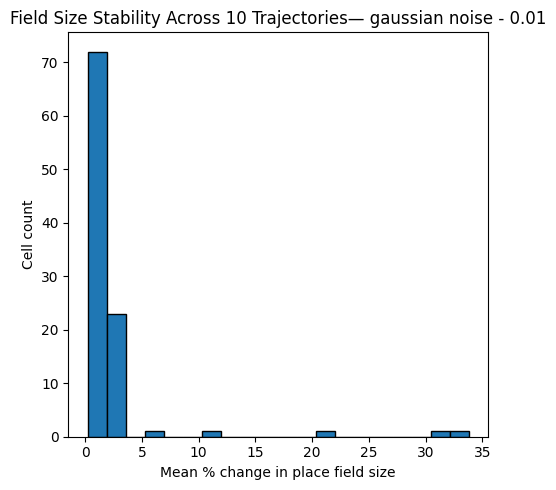


——— All Pairwise Trial Consistency (Per Cell) ———
Mean correlation (excl. NaN): 0.706
Mean % change in field size: 3.3%
Mean place field size (across all trials): 67.71


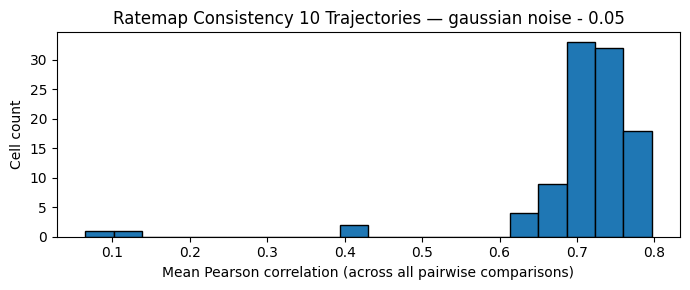

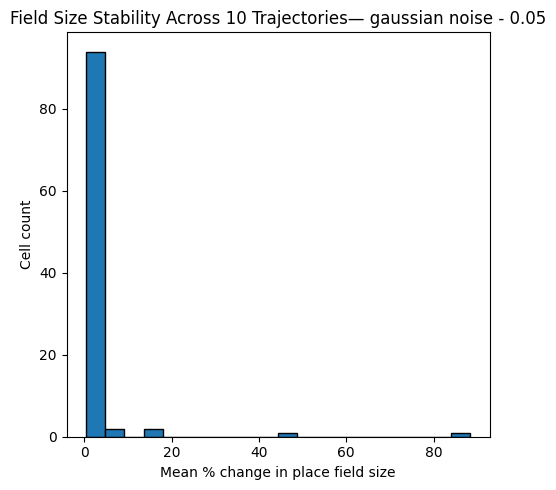


——— All Pairwise Trial Consistency (Per Cell) ———
Mean correlation (excl. NaN): 0.723
Mean % change in field size: 3.1%
Mean place field size (across all trials): 67.11


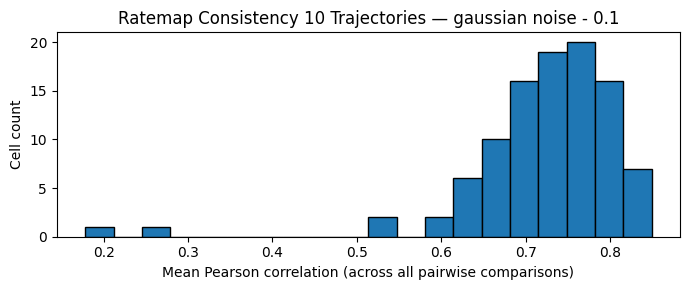

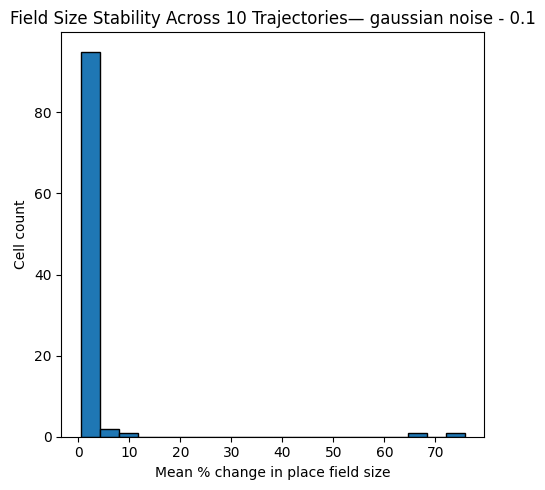


——— All Pairwise Trial Consistency (Per Cell) ———
Mean correlation (excl. NaN): 0.733
Mean % change in field size: 2.8%
Mean place field size (across all trials): 67.44


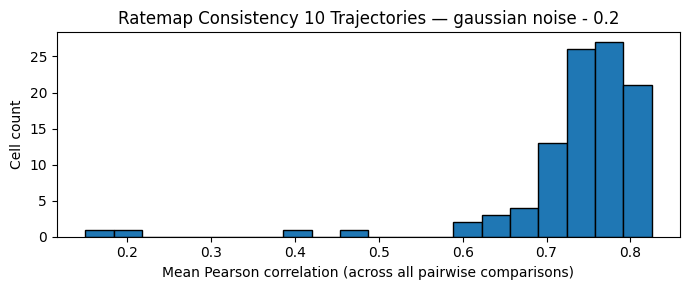

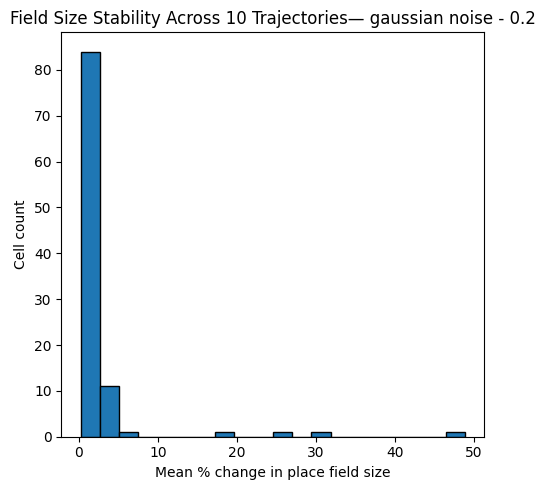


——— All Pairwise Trial Consistency (Per Cell) ———
Mean correlation (excl. NaN): 0.709
Mean % change in field size: 2.7%
Mean place field size (across all trials): 67.10


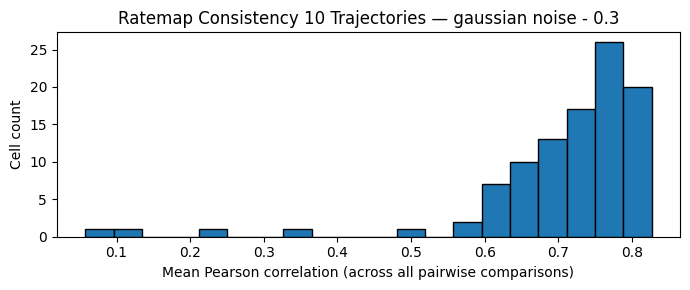

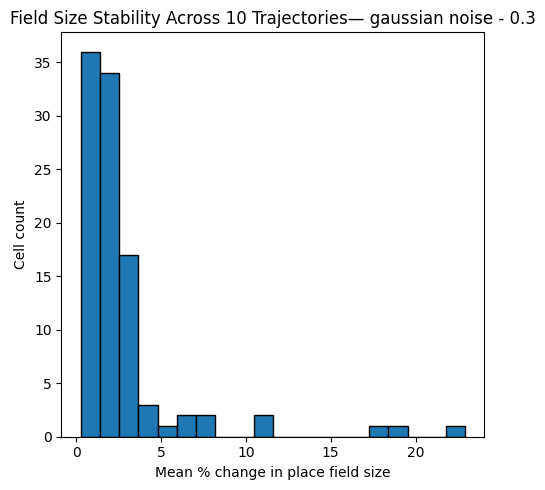


——— All Pairwise Trial Consistency (Per Cell) ———
Mean correlation (excl. NaN): 0.699
Mean % change in field size: 2.8%
Mean place field size (across all trials): 67.70


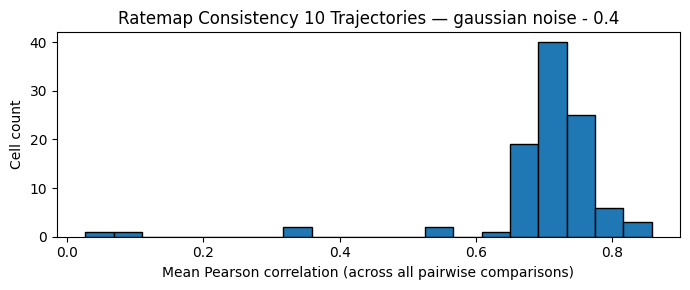

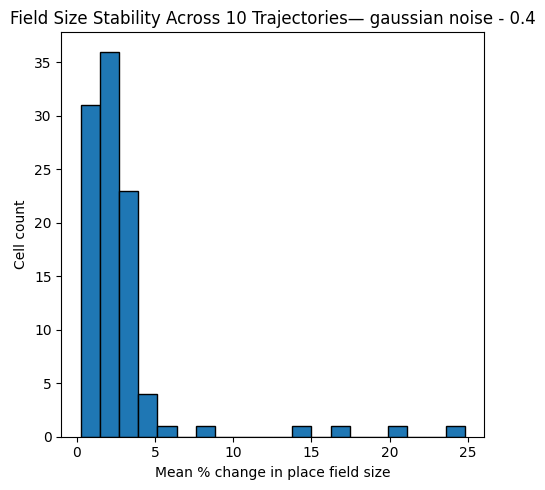


——— All Pairwise Trial Consistency (Per Cell) ———
Mean correlation (excl. NaN): 0.744
Mean % change in field size: 2.6%
Mean place field size (across all trials): 67.02


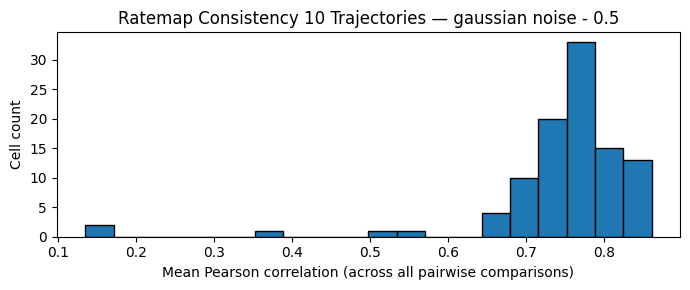

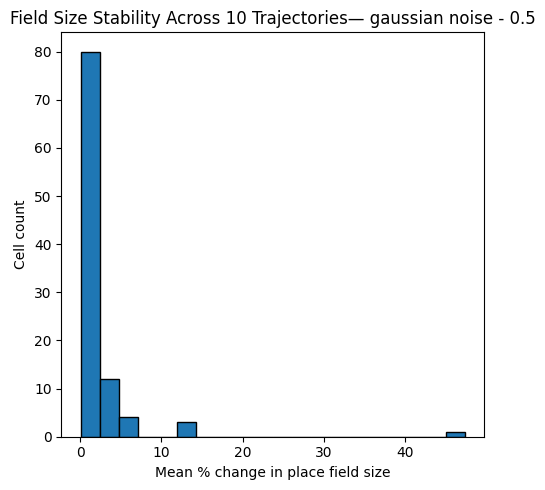


——— All Pairwise Trial Consistency (Per Cell) ———
Mean correlation (excl. NaN): 0.719
Mean % change in field size: 3.5%
Mean place field size (across all trials): 67.24


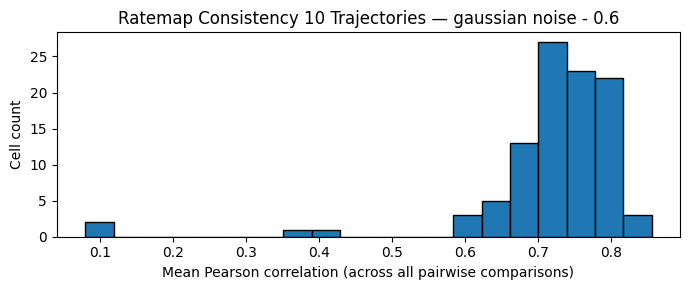

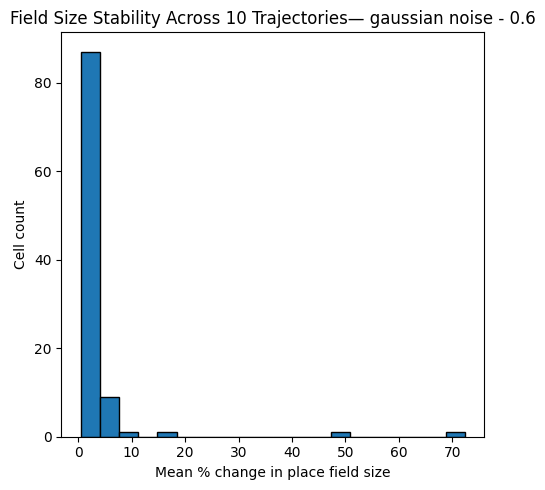


——— All Pairwise Trial Consistency (Per Cell) ———
Mean correlation (excl. NaN): 0.711
Mean % change in field size: 2.6%
Mean place field size (across all trials): 67.56


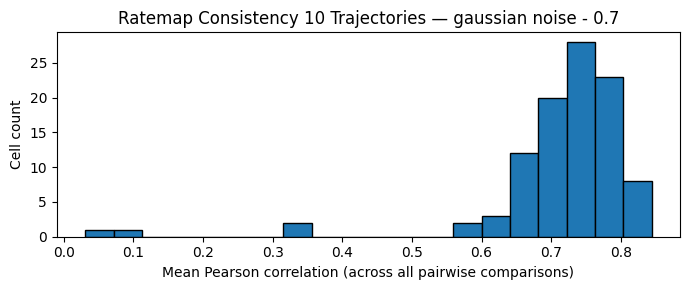

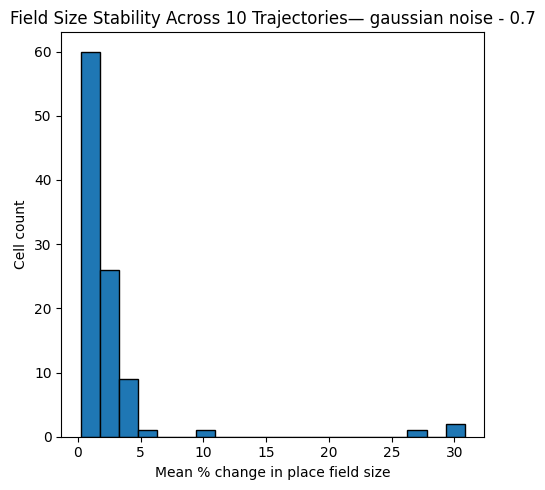

In [303]:
cell_deletion_percent = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]

for sigma in noise_levels:
    corrs, pct_changes, mean_field_size = ratemap_consistency_all_pairs(
        pipeline_fn=run_cell_deletion_pipeline,
        num_runs=10,
        bin_area=4.0,
        label=f"cell deletion - {cell_deletion_percent}",
        pipeline_kwargs={"cell_deletion_percent": cell_deletion_percent}
    )

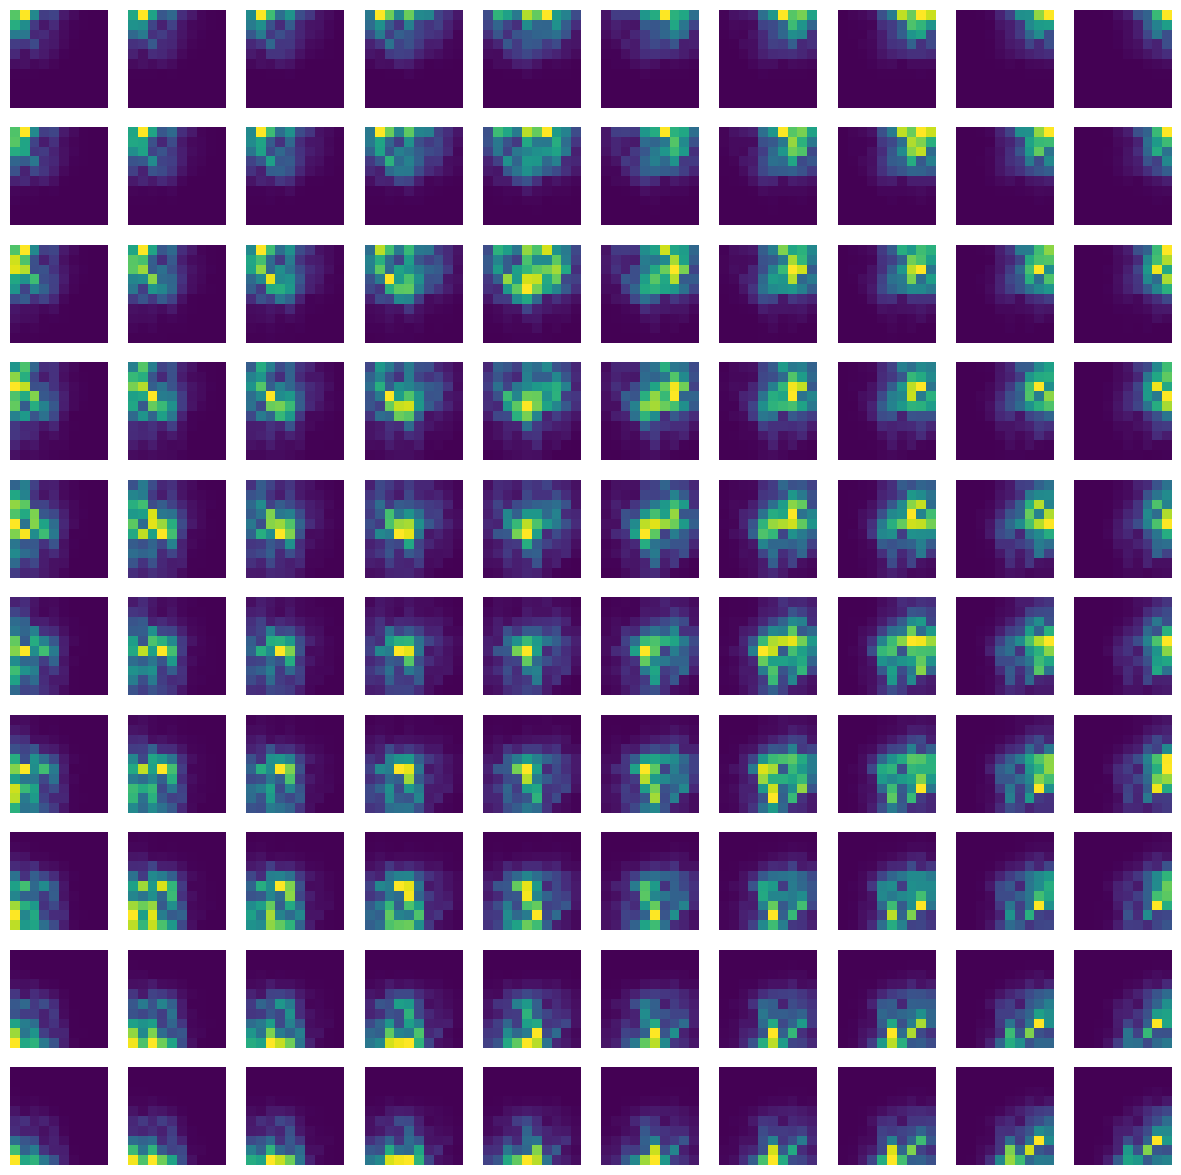

In [140]:
fig, axes = plt.subplots(10, 10, figsize=(15, 15))
axes = axes.flatten()
for i in range(100):
    ax = axes[i]
    ax.imshow(rate[i])
    ax.axis('off')